In [1]:
import h5py as h5py 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
print(os.listdir("/kaggle/input/data"))

['images_003', 'images_012', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'images_009', 'images_008', 'images_007', 'test_list.txt', 'images_010', 'ARXIV_V5_CHESTXRAY.pdf', 'images_002', 'images_011', 'Data_Entry_2017.csv', 'images_001', 'train_val_list.txt', 'images_005', 'FAQ_CHESTXRAY.pdf', 'images_004', 'images_006']


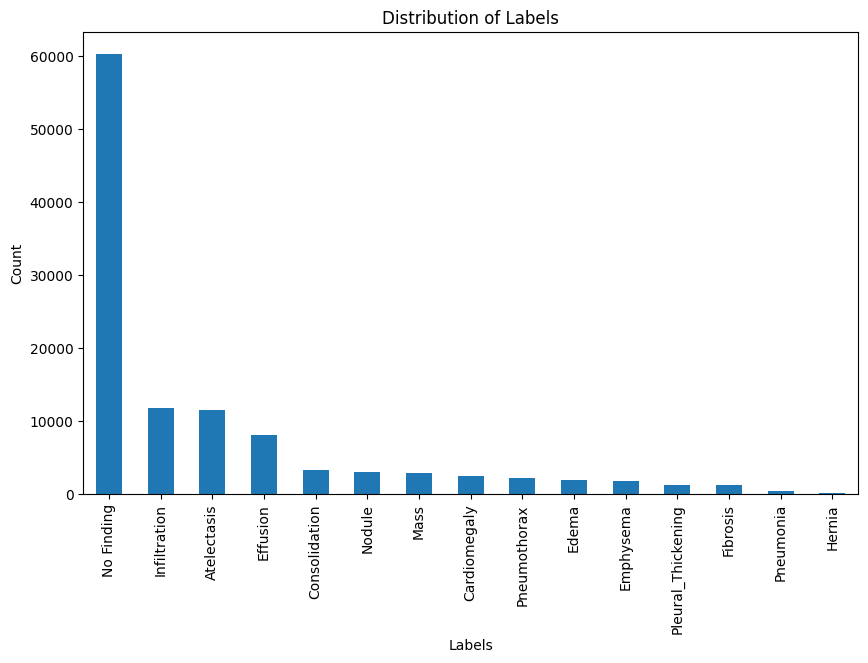

Finding Labels
No Finding            60361
Infiltration          11795
Atelectasis           11545
Effusion               8040
Consolidation          3331
Nodule                 3009
Mass                   2926
Cardiomegaly           2404
Pneumothorax           2200
Edema                  1862
Emphysema              1734
Pleural_Thickening     1217
Fibrosis               1215
Pneumonia               325
Hernia                  156
Name: count, dtype: int64


In [4]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(r"/kaggle/input/data/Data_Entry_2017.csv")

# Remove the line that replaces 'No Finding'
# df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.split('|')[0])
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.split(','))
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x[0])
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.strip())


plt.figure(figsize=(10,6))
df['Finding Labels'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# Print the count of all labels
print(df['Finding Labels'].value_counts())

In [5]:
# Initialize a dictionary to store the counts
import torch.nn as nn
label_counts = {}
label_map={'Emphysema':0,
           'Effusion':1,
           'Nodule':2,
           'Pneumothorax':3,
           'Atelectasis':4,
           'Pleural_Thickening':5,
           'Mass':6,
           'Edema':7,
           'Consolidation':8,
           'Infiltration':9,
           'Fibrosis':10,
           'Pneumonia':11,
           'No Finding':12
          }
print("Length of labels are :",len(label_map))

# Iterate over the labels
for label in label_map.keys():
    # Count the number of times each label appears in the 'Finding Labels' column
    label_counts[label] = df['Finding Labels'].str.contains(label).sum()

# Calculate class weights
total_count = sum(label_counts.values())
class_weights = {k: total_count/v for k, v in label_counts.items()}

# Convert class weights to tensor
# weights = [class_weights[i] for i in range(len(class_weights))]
# class_weights_tensor = torch.FloatTensor(weights).to(device)

# Convert class weights to tensor
weights = [class_weights[label] for label in label_map.keys()]
class_weights_tensor = torch.FloatTensor(weights).to(device)

# Define your criterion with the class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

# Print the counts and class weights
for label, count in label_counts.items():
    print(f'Label {label}: {count} images, weight: {class_weights[label]}')

Length of labels are : 13
Label Emphysema: 1734 images, weight: 63.18339100346021
Label Effusion: 8040 images, weight: 13.626865671641792
Label Nodule: 3009 images, weight: 36.410767696909275
Label Pneumothorax: 2200 images, weight: 49.8
Label Atelectasis: 11545 images, weight: 9.489822433954092
Label Pleural_Thickening: 1217 images, weight: 90.02465078060806
Label Mass: 2926 images, weight: 37.443609022556394
Label Edema: 1862 images, weight: 58.83995703544576
Label Consolidation: 3331 images, weight: 32.89102371660162
Label Infiltration: 11795 images, weight: 9.288681644764731
Label Fibrosis: 1215 images, weight: 90.17283950617283
Label Pneumonia: 325 images, weight: 337.10769230769233
Label No Finding: 60361 images, weight: 1.8150792730405394


In [6]:
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
class NIH_Chest_Xray_Dataset(Dataset):
    def __init__(self, data_dir, df, label_map, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.df = df
        self.label_map = label_map

        for i, row in self.df.iterrows():
            img_name = row['Image Index']
            labels = row['Finding Labels'].split("|")
            # Only include the image if its label is in label_map
            if any(label in self.label_map for label in labels):
                for i in range(1, 13):
                    img_path = os.path.join(self.data_dir, f'images_{str(i).zfill(3)}/images/', img_name)
                    if os.path.isfile(img_path):
                        self.image_paths.append(img_path)
                        self.labels.append(labels)
                        break

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        labels = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        num_labels = len(self.label_map)
        binary_label = torch.zeros(num_labels)

        for label in labels:
            if label in self.label_map:
                binary_label[self.label_map[label]] = 1

        return img, binary_label

In [7]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
data_dir = '/kaggle/input/data'
df = pd.read_csv(os.path.join(data_dir, 'Data_Entry_2017.csv'))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split the DataFrame into a training set and a test set
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Create the train and test datasets 
train_dataset = NIH_Chest_Xray_Dataset(data_dir, train_df, label_map, transform=transform)
test_dataset = NIH_Chest_Xray_Dataset(data_dir, test_df, label_map, transform=transform)

print('DF size (Total) ',len(df))
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


DF size (Total)  112120
Train dataset size: 99811
Test dataset size: 11104


In [8]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [9]:
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.models import vision_transformer

#model.head = torch.nn.Linear(out_features=14,in_features=768)  #14
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 
#pretrained_vit_weights=torchvision.models.vit_l_16(pretrained=True)

# Setup a ViT model instance with pretrained weights
#model = torchvision.models.vit_l_16(weights=pretrained_vit_weights)
model = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

# Freeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = False
    
# change your out_features according to number of classes defined, we have 14 classes 
#model.heads = nn.Linear(in_features=1024, out_features=13)
model.heads = nn.Linear(in_features=768, out_features=13)

model.to(device)  # to put the whole architecture to gpu memory
#print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 63.6MB/s]


# run this next code cell for scratch training

In [10]:
# import torch.nn as nn
# import torch.optim as optim
# from torchvision.models import vit_b_16
# from torchvision.models import vit_l_16

# # Setup a ViT model instance without pretrained weights
# model = vit_l_16(pretrained=False)

# # Freeze the base parameters
# for parameter in model.parameters():
#     parameter.requires_grad = False
    
# # Change your out_features according to number of classes defined, we have 14 classes 
# #model.heads = nn.Linear(in_features=768, out_features=13) #for vit_b_16
# model.heads = nn.Linear(in_features=1024, out_features=13) #for vit_l_16

# model.to(device)  # To put the whole architecture to GPU memory
# print(model)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

------------------------------------------------------------------------------------------

In [11]:
from tqdm import tqdm

model.train()
num_epochs = 6

train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies

for epoch in range(num_epochs):
    running_loss = 0.0
    corrects = torch.zeros(13).to(device)  # change torch.zeros(No.classes) according to classes defined above
    total_samples = 0
    
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Calculate training accuracy
        predicted_labels = torch.sigmoid(outputs) > 0.5
        corrects += (predicted_labels == labels).sum(dim=0).float()
        total_samples += images.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = corrects / total_samples
    
    # Print and save training loss and accuracy
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {}'.format(epoch+1, num_epochs, epoch_loss, epoch_accuracy.tolist()))
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy.tolist())


100%|██████████| 3120/3120 [27:59<00:00,  1.86it/s]


Epoch [1/6], Loss: 1.5270, Accuracy: [0.571550190448761, 0.5707988142967224, 0.1845988780260086, 0.38862448930740356, 0.6011361479759216, 0.2008696347475052, 0.2663734257221222, 0.7087194323539734, 0.5639959573745728, 0.31723958253860474, 0.49879270792007446, 0.06688641011714935, 0.6226868629455566]


100%|██████████| 3120/3120 [25:19<00:00,  2.05it/s]


Epoch [2/6], Loss: 1.4995, Accuracy: [0.6042720675468445, 0.5868892073631287, 0.207822784781456, 0.4264259338378906, 0.6094117760658264, 0.22443416714668274, 0.29272323846817017, 0.7169349789619446, 0.5753373503684998, 0.326066255569458, 0.5244912505149841, 0.11036859452724457, 0.6250613331794739]


100%|██████████| 3120/3120 [25:55<00:00,  2.01it/s]


Epoch [3/6], Loss: 1.4933, Accuracy: [0.6002143621444702, 0.5873700976371765, 0.21729066967964172, 0.4392201006412506, 0.609431803226471, 0.2434501051902771, 0.2962799668312073, 0.7191792130470276, 0.5763092041015625, 0.3237919509410858, 0.5334081053733826, 0.11494724452495575, 0.6278566122055054]


100%|██████████| 3120/3120 [27:39<00:00,  1.88it/s]


Epoch [4/6], Loss: 1.4943, Accuracy: [0.6011962294578552, 0.5894440412521362, 0.20559857785701752, 0.43417057394981384, 0.6093215942382812, 0.23133721947669983, 0.29578903317451477, 0.7191391587257385, 0.5769404172897339, 0.323471337556839, 0.5328971743583679, 0.1224915012717247, 0.6254721283912659]


100%|██████████| 3120/3120 [26:31<00:00,  1.96it/s]


Epoch [5/6], Loss: 1.4946, Accuracy: [0.6082395315170288, 0.5853462815284729, 0.2146957665681839, 0.4352726638317108, 0.6081494092941284, 0.23222890496253967, 0.29198184609413147, 0.7205818891525269, 0.5779122114181519, 0.32085639238357544, 0.5358126759529114, 0.10760336369276047, 0.625963032245636]


100%|██████████| 3120/3120 [26:49<00:00,  1.94it/s]

Epoch [6/6], Loss: 1.4939, Accuracy: [0.6009557843208313, 0.58919358253479, 0.21692998707294464, 0.42704710364341736, 0.6063058972358704, 0.23010489344596863, 0.294656902551651, 0.7201811075210571, 0.5772910714149475, 0.3291320502758026, 0.5348508358001709, 0.11324402689933777, 0.6249611377716064]


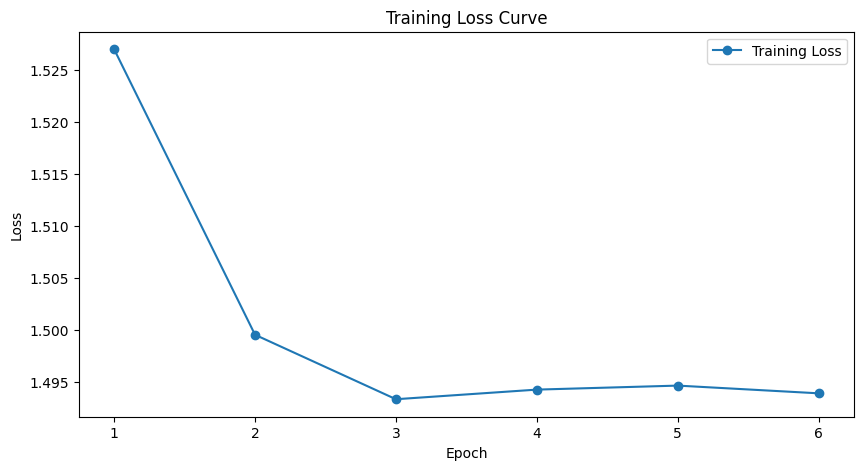

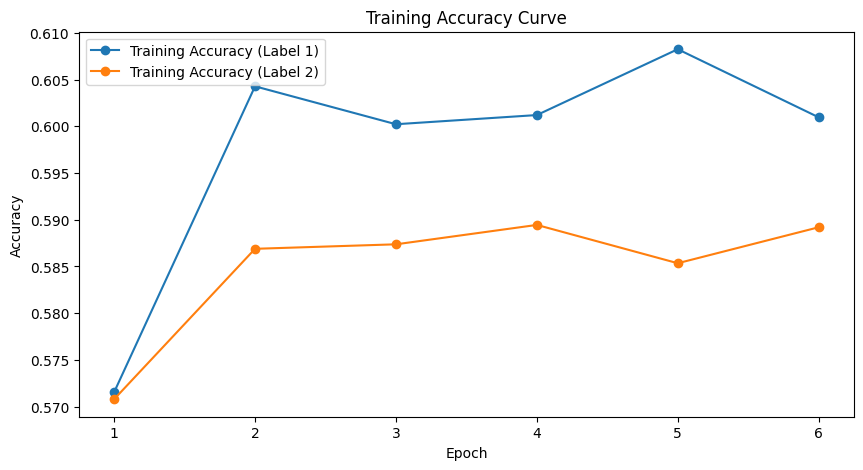

In [12]:
import matplotlib.pyplot as plt

# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy curve
plt.figure(figsize=(10, 5))
for i in range(2):  # Plot accuracy for each label
    plt.plot(range(1, num_epochs+1), [acc[i] for acc in train_accuracies], marker='o', label=f'Training Accuracy (Label {i+1})')

plt.title('Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [13]:
torch.save(model.state_dict(), 'weights.pth')

In [14]:
#Evaluate
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt

model.eval()
auc_scores = []    
running_loss = 0.0
running_corrects = torch.zeros(13).to(device)
total_samples = 0
num_labels = 13  # change lables here
with torch.no_grad():
    y_true = []
    y_pred = []
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        predicted_labels = torch.sigmoid(outputs) > 0.5
        predicted_probs = torch.sigmoid(outputs)
                
        running_corrects += (predicted_labels == labels).sum(dim=0).float()
        total_samples += inputs.size(0)
        y_pred.append(predicted_probs.cpu().numpy())
        y_true.append(labels.cpu().numpy())

epoch_loss = running_loss / total_samples
epoch_acc = running_corrects / total_samples
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)
fpr, tpr, thresholds = roc_curve(y_true.ravel(), y_pred.ravel())
auc_score = roc_auc_score(y_true, y_pred, average='macro')

#auc_score = roc_auc_score(y_true, y_pred, multi_class='ovr') 
print(f'Validation Loss: {epoch_loss:.4f} | Validation Acc: {epoch_acc.tolist()} | AUC score: {auc_score:.4f}')

100%|██████████| 347/347 [03:16<00:00,  1.77it/s]

Validation Loss: 1.4910 | Validation Acc: [0.40381842851638794, 0.48297908902168274, 0.11338256299495697, 0.4843299686908722, 0.746577799320221, 0.07627881318330765, 0.36473342776298523, 0.7151476740837097, 0.5989733338356018, 0.19434437155723572, 0.5887967944145203, 0.1255403459072113, 0.6569704413414001] | AUC score: 0.7389


100%|██████████| 347/347 [03:03<00:00,  1.89it/s]


{'Emphysema': {'precision': 0.03237044563797358, 'recall': 0.9291666666666667, 'f1-score': 0.06256136905596858, 'support': 240}, 'Effusion': {'precision': 0.1838351822503962, 'recall': 0.9444855662472242, 'f1-score': 0.3077665219488664, 'support': 1351}, 'Nodule': {'precision': 0.058266360505166474, 'recall': 0.9886363636363636, 'f1-score': 0.1100469822912902, 'support': 616}, 'Pneumothorax': {'precision': 0.0773002124530152, 'recall': 0.9131274131274131, 'f1-score': 0.1425342775350309, 'support': 518}, 'Atelectasis': {'precision': 0.21236559139784947, 'recall': 0.5683453237410072, 'f1-score': 0.30919765166340507, 'support': 1112}, 'Pleural_Thickening': {'precision': 0.03023983315954119, 'recall': 0.996875, 'f1-score': 0.05869905235072223, 'support': 320}, 'Mass': {'precision': 0.06665776115415442, 'recall': 0.8633217993079585, 'f1-score': 0.12375992063492063, 'support': 578}, 'Edema': {'precision': 0.05893129770992366, 'recall': 0.8654708520179372, 'f1-score': 0.11034877072612921, 'su

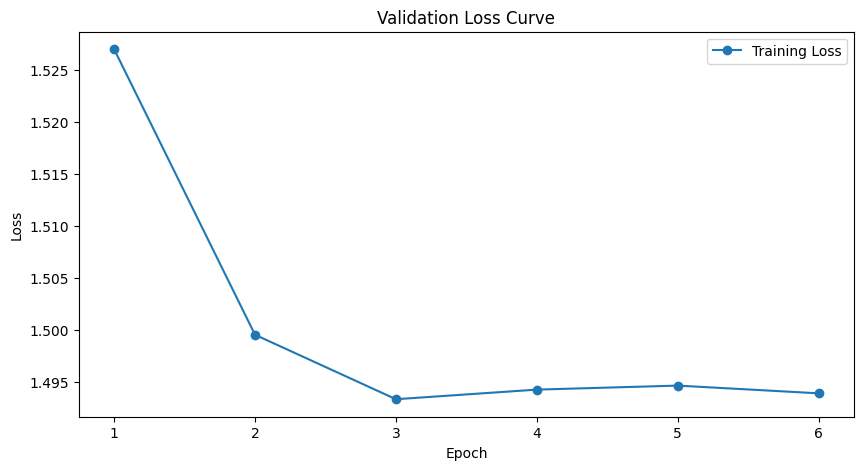

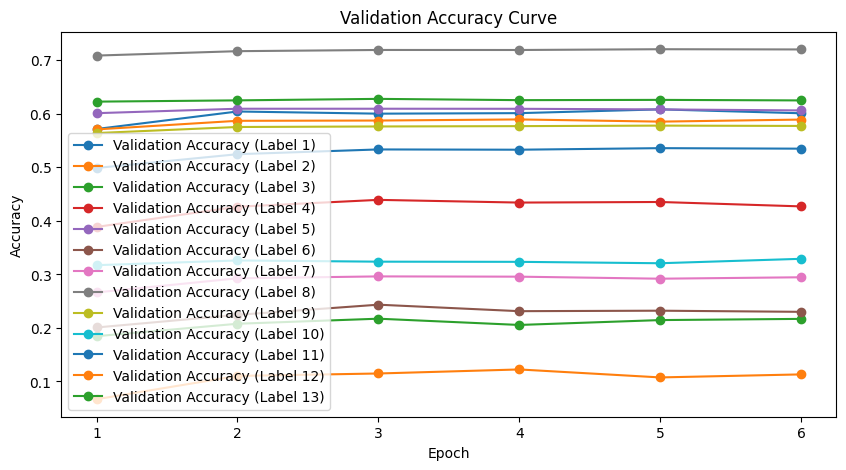

In [15]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


model.eval()
auc_scores = []    
running_loss = 0.0
running_corrects = torch.zeros(13).to(device)
total_samples = 0
num_labels = 13  # Change the number of labels here

with torch.no_grad():
    y_true = []
    y_pred = []
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        predicted_labels = torch.sigmoid(outputs) > 0.5
        predicted_probs = torch.sigmoid(outputs)
                
        running_corrects += (predicted_labels == labels).sum(dim=0).float()
        total_samples += inputs.size(0)
        y_pred.append(predicted_probs.cpu().numpy())
        y_true.append(labels.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    fpr, tpr, thresholds = roc_curve(y_true.ravel(), y_pred.ravel())
    auc_score = roc_auc_score(y_true, y_pred, average='macro')

    
    
# Convert probabilities to class labels
    y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate and print the classification report
    report = classification_report(y_true, y_pred_labels, target_names=label_map.keys(), output_dict=True)
    print(report)

# Calculate and print the average F1 score, recall, and specificity
    avg_f1 = np.mean([report[label]['f1-score'] for label in label_map.keys()])
    avg_recall = np.mean([report[label]['recall'] for label in label_map.keys()])
    avg_specificity = np.mean([1 - report[label]['recall'] for label in label_map.keys()])

    print(f'Average F1 Score: {avg_f1}')
    print(f'Average Recall: {avg_recall}')
    print(f'Average Specificity: {avg_specificity}')

# Print validation loss, accuracy, and AUC score
    print(f'Validation Loss: {epoch_loss:.4f} | Validation Acc: {epoch_acc.tolist()} | AUC score: {auc_score:.4f}')


    # Print validation loss, accuracy, and AUC score
    print(f'Validation Loss: {epoch_loss:.4f} | Validation Acc: {epoch_acc.tolist()} | AUC score: {auc_score:.4f}')

    # Plotting accuracy and loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Training Loss')
    plt.title('Validation Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for i in range(num_labels):  # Plot accuracy for each label
        plt.plot(range(1, num_epochs+1), [acc[i] for acc in train_accuracies], marker='o', label=f'Validation Accuracy (Label {i+1})')

    plt.title('Validation Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

   

In [16]:
# # plot the ROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Plot Curve')
# plt.legend(loc="lower right")
# plt.show()


# # Confusion matrix
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import numpy as np

# # Convert lists to numpy arrays
# y_true_np = np.array(y_true)
# y_pred_np = np.array(y_pred)

# # Calculate confusion matrix
# #conf_mat = confusion_matrix(y_true_np.argmax(axis=1), y_pred_np.argmax(axis=1))

# #conf_mat = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

# plt.figure(figsize=(10, 10))
# sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()

# # Precision-recall curve
# from sklearn.metrics import precision_recall_curve

# precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

# plt.figure()
# plt.plot(recall, precision, color='darkorange', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.show()

# # Histogram of predicted probabilities
# plt.figure()
# plt.hist(y_pred.ravel(), bins=20)
# plt.xlabel('Predicted Probability')
# plt.ylabel('Frequency')
# plt.title('Histogram of Predicted Probabilities')
# plt.show()

In [17]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.0 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=61d3b0a0fff6bfce32b1d71af0392fe47cea935cf59511636373452752b4b24a
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


In [18]:
!pip install timm

In [19]:
import cv2
import numpy as np
import torch
from torchvision import transforms
import timm
#from your_module import ViT_B_16  # Import your ViT model
from torchvision.models import vision_transformer as vit
from torchvision.models import vision_transformer
from pytorch_grad_cam import GradCAM    
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

if __name__ == '__main__':
    use_cuda = torch.cuda.is_available()
    image_path = r'/kaggle/input/data/images_004/images/00006585_008.png'
    aug_smooth = False
    eigen_smooth = False
    method = 'gradcam'

    if use_cuda:
        print('Using GPU for acceleration')
    else:
        print('Using CPU for computation')

    # Load your ViT model
    #model = ViT_B_16(pretrained=True) 
    # Adjust the parameters accordingly
    #model = vit.vit_base_patch16_224(pretrained=True)
    # Get pretrained weights for ViT-Base
    pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# Setup a ViT model instance with pretrained weights
    #model = torchvision.models.vit_b_16(weights=pretrained_vit_weights)
    model = timm.create_model('vit_base_patch16_224', pretrained=True)  # Adjust the parameters accordingly

    model.eval()

    if use_cuda:
        model = model.cuda()

    target_layers = [model.blocks[-1].norm1]

    methods = {"gradcam": GradCAM}

    if method not in list(methods.keys()):
        raise Exception(f"method should be one of {list(methods.keys())}")

    if method == "ablationcam":
        cam = methods[method](model=model,
                              target_layers=target_layers,
                              reshape_transform=reshape_transform,
                              ablation_layer=AblationLayerVit())
    else:
        cam = methods[method](model=model,
                              target_layers=target_layers,
                              reshape_transform=reshape_transform)

    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])

    targets = None

    cam.batch_size = 32

    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        eigen_smooth=eigen_smooth,
                        aug_smooth=aug_smooth)

    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    cv2.imwrite(f'{method}_cams8.jpg', cam_image)
    #cv2.imshow(f'{method}_cams.jpg', cam_image)


Using GPU for acceleration


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]